## Setting up GPU support

In [1]:
import plaidml.keras
plaidml.keras.install_backend()
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

## Imports

In [185]:
import numpy as np

from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, Flatten
from keras import Sequential

Adapted from this tutorial https://www.tensorflow.org/tutorials/images/transfer_learning

In [186]:
IMG_SHAPE = (224,224,3)

base_model = MobileNetV2(input_shape=IMG_SHAPE,
                        include_top=False,
                        weights='imagenet')

base_model.trainable = False

In [187]:
model = Sequential([
    base_model,
    Flatten(),  #GlobalAveragePooling2D(),
    Dense(1,activation='sigmoid')
])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_3 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 62721     
Total params: 2,320,705
Trainable params: 62,721
Non-trainable params: 2,257,984
_________________________________________________________________


## Generator

### Dataframe to hold images paths

In [148]:
import os
from pathlib import Path
import glob
import pandas as pd
pd.set_option('max_colwidth', 800)

In [152]:
BASE_DIR = Path('../../../../')
DATA_DIR = BASE_DIR.joinpath('datasets','thick_smears_150_x2')

In [6]:
def read_info(csv_path):
    path = Path(csv_path)
    temp = pd.read_csv(path)
    temp.id = temp.id.apply(lambda s: os.path.join(path.parent.resolve(),s+'.jpg'))
    return temp

In [110]:
all_files = glob.glob(os.path.join(DATA_DIR,'*/*/*.csv'))

df = pd.concat(map(read_info,all_files))
L = df.shape[0]

mu = (df.label.value_counts()/L)[0]
print('Baseline accuracy: {:.2f}%'.format(100*mu)) 

df.label = df.label.apply(lambda x: 'Parasite' if x else 'No Parasite')
df = df.sample(frac=1).reset_index(drop=True)  # Shuffle

Baseline accuracy: 62.53%


### Image loading and augmentation

In [188]:
from keras.preprocessing.image import ImageDataGenerator

In [237]:
image_datagen = ImageDataGenerator(zoom_range=0.1,
                                   #width_shift_range=0.1,
                                   #height_shift_range=0.1,
                                   #rotation_range=360,   # Can cause distortions
                                   fill_mode = 'constant',
                                   cval = 0,
                                   preprocessing_function=preprocess_input,
                                   
                                  )

In [238]:
kwargs = dict(x_col='id',
              y_col='label',
              class_mode='binary',
              target_size=(224,224),
              batch_size=64,
              seed=2020)

# Train/test split - OK to do it by position because df is already shuffled
idx = int(L*0.9)
train_data = image_datagen.flow_from_dataframe(df.iloc[:idx], **kwargs)
test_data = image_datagen.flow_from_dataframe(df.iloc[idx:], **kwargs)

Found 21913 validated image filenames belonging to 2 classes.
Found 2435 validated image filenames belonging to 2 classes.


## Training

### Callbacks

In [195]:
from keras.callbacks import TensorBoard, CSVLogger,  EarlyStopping

In [196]:
callbacks = [
    #TensorBoard(log_dir=BASE_DIR.joinpath('tboard'),update_freq='batch'), # Does not work with PlaidML
    CSVLogger('training_log.csv'),
    EarlyStopping(patience=2, restore_best_weights=True)
]

### Training loop

In [197]:
#from keras.losses import binary_crossentropy

In [225]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit_generator(generator=train_data,
                              validation_data=test_data,
                              epochs=10,
                              callbacks=callbacks,
                             )

In [ ]:
pd.DataFrame(history.history).plot();

### Visual inspection

In [239]:
import matplotlib.pyplot as plt
%matplotlib inline

In [240]:
X,y =  test_data.next()

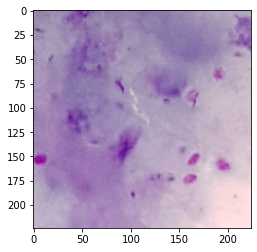

In [241]:
sample = X[0]
sample -= sample.min()
sample /= sample.max()

plt.imshow(sample);

In [243]:
yy = model.predict(X).round()
yy[0]

array([1.], dtype=float32)

### Measure model performance

In [244]:
from sklearn.metrics import classification_report, confusion_matrix

In [245]:
print(classification_report(y, yy, target_names=['No Parasite','Parasite']))

              precision    recall  f1-score   support

 No Parasite       0.78      0.37      0.50        38
    Parasite       0.48      0.85      0.61        26

    accuracy                           0.56        64
   macro avg       0.63      0.61      0.56        64
weighted avg       0.66      0.56      0.55        64

